# Crystallisation time and Plagioclase shape calibration in sills

Here we follow the procedure of Holness (2014) to calibrate the relationship between plagioclase shape and crystallisation time in sills using segmentation results with the DL method. The calibration itself will be performed using an MCMC approach to allow us to quantify the uncertainty in modelling based on the uncertainties in determining plagioclase shape. Uncertainties in the measured crystal aspect ratio are calculated using the bootstrap method utilized in the original publication by the author.

In [39]:
import numpy as np
import matplotlib.pyplot as plt

#function to calculate expected cooling time
def cooling_time(x, w, centre = True):
    x = np.abs(w/2 - x)
    k = 10**(-6)
    t =  0.1*((w**2)/k)*(1+np.cos((2*np.pi*x)/w))
    return t/(365.25*24*3600)

In [42]:
#details from Holness (2014) & Holness (2017)
marian = [2.14, 2.25, 3.21, 3.04, 3.21, 3.17, 3.05, 4.4, 4.09, 3.49, 2.68, 2.42, 2.06, 3.20, 3.42,3.17, 3.43,
         3.6,3.57,3,3.12,3.3]
marian_upper = [2.47,2.36,3.56,3.19,3.37,3.33,3.25,4.67,4.31,3.67,2.77,2.49,2.17,3.44,3.56,3.3,3.63,
               3.73,3.78,3.12,3.24,3.44]
marian_lower = [2,2.1,3.17,2.84,3.02,3.00,2.89,4.24,3.80,3.32,2.56,2.27,1.94,2.95,3.28,3,3.2,
               3.46,3.37,2.78,2.89,3.13]

w = [362, 362, 151,151,151,151,151,3.5,3.5,151,362,362,362, 151, 38.56,38.56,38.56,38.56,38.56,38.56,38.56,38.56]
x = [107,69.7,1,55,80,100,140, 1.69,1.06,124, 20,38.5,181.7, 21.8, 1.01,3.93,0.36,0.67,1.75,8.8,5.36,3.28]
names = ["ac", "ac", "kh", "kh", "kh", "kh", "kh", "rom", "rom", "kh", "ac", "ac", "ac", "kh", "ws","ws","ws","ws"
        ,"ws","ws","ws","ws"]

tc = cooling_time(np.asarray(x), np.asarray(w))

#pos = 0.5 means sample is at the edge/margin of intrusion, 0 means centre
pos = np.abs(np.asarray(w)/2 - np.asarray(x))/np.asarray(w)

### Loading in the results

Textural data - aspect ratio and size - are held in the "props" folder.

In [44]:
# NOTING that KH12 was misspelt as KH15 - it's actually KH12 
samples = ["AC38", "AC44", "KH1","KH15", "KH17", "KH22", "KH30", "ROM48_106", "ROM48-169", "KH27",
           "AC-55", "AC-49", "AC-13", "KH6", "E37042", "E37074", "E37083", "E37081", "E37079", "E37062",
           "E37052", "E37047"]

In [45]:
#load in the data itself
ar = []
size = []
for item in samples:
    data = np.load("sill_props/" + item + "_props.npz")
    ar.append(data["ar"])
    size.append(data["size"])

In [46]:
from scipy.stats import bootstrap
#perform bootstrap
conf_int = []
for item in ar:
    res = bootstrap((item,),np.mean, n_resamples=100, batch = 100)
    conf_int.append([res.confidence_interval[0], res.confidence_interval[1]])

#### See how the two datasets compare

In [49]:
m = [np.mean(ar[i]) for i in range(len(samples))]
from scipy.stats import pearsonr
pearsonr(m, marian)

PearsonRResult(statistic=0.8146085479350239, pvalue=3.928654523474867e-06)

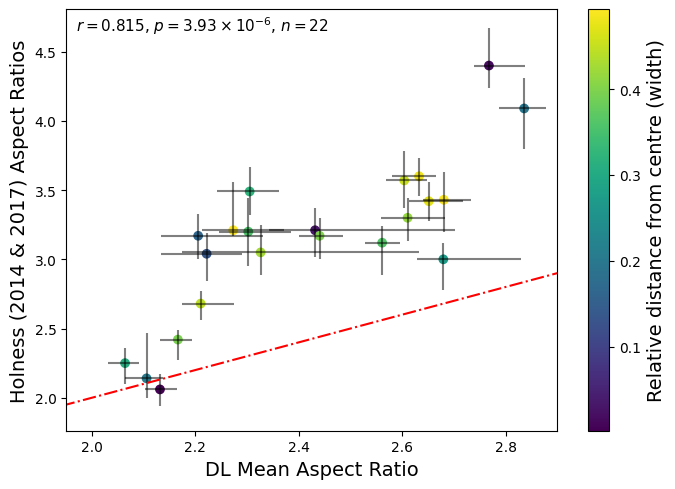

In [48]:
#Pearson's correlation coefficient suggests strong correlation
#No 1-to-1 match as you see below

fig, ax = plt.subplots(1,1,figsize = (7,5))

ax.errorbar(m, marian,
 xerr=[m-np.asarray(conf_int)[:,0],np.asarray(conf_int)[:,1]-m],
 yerr = [np.asarray(marian)-np.asarray(marian_lower), np.asarray(marian_upper)-np.asarray(marian)],
 fmt = '', linestyle = '', color = 'k', alpha = 0.5)
mappable = ax.scatter(m, marian, c = pos)
cbar = plt.colorbar(mappable)
cbar.set_label("Relative distance from centre (width)", size = 14)
ax.plot([1.9,3.5], [1.9,3.5], 'r-.')
fig.tight_layout()
ax.set_xlim([1.95,2.9])
ax.set_xlabel("DL Mean Aspect Ratio", size = 14)
ax.set_ylabel("Holness (2014 & 2017) Aspect Ratios", size = 14)
ax.text(1.97, 4.65,r"$r = 0.815$, $p = 3.93\times 10^{-6}$, $n =22$", size = 11)
fig.tight_layout()

#### Calibration of expected relationship

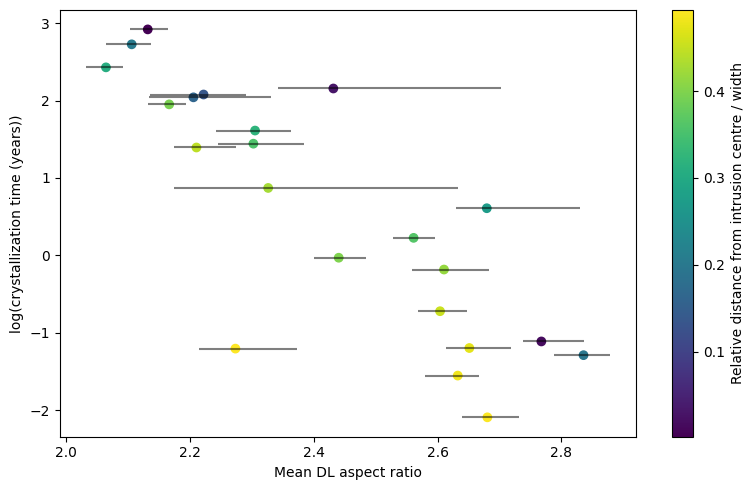

In [50]:
m = [np.mean(ar[i]) for i in range(len(samples))]

fig, ax = plt.subplots(1,1,figsize = (8,5))

ax.errorbar(m, np.log10(tc),
 xerr=[m-np.asarray(conf_int)[:,0],np.asarray(conf_int)[:,1]-m],
 fmt = '', linestyle = '', color = 'k', alpha = 0.5)
mappable = plt.scatter(m, np.log10(tc),c=pos, cmap = "viridis")
cbar = plt.colorbar(mappable)
cbar.set_label("Relative distance from intrusion centre / width")
ax.set_ylabel("log(crystallization time (years))")
ax.set_xlabel("Mean DL aspect ratio")
fig.tight_layout()

In [51]:
#get rid of samples too close to margin as done by Holness (2014)
filter_arr = pos <0.45
err = 0.5*(np.asarray(conf_int)[:,1]- np.asarray(conf_int)[:,0])
conf_int_mean = np.mean(conf_int, axis = 1)

Here we will perform the MCMC fitting procedure.

We impose a Gaussian likelihood function as we can safely assume the uncertainties on x follow a normal distribution invoking the central limit theorem on bootstrapping. We set fairly uninformative priors on both m and c with the parameters set to lie in the intervals [-10, 0] and [0, 25] repesctively. 

In [52]:
import bilby


class GaussianLikelihoodUncertainX(bilby.core.likelihood.Likelihood):
    def __init__(self, xobs, yobs, xerr, yerr, function):
        """

        Parameters
        ----------
        xobs, yobs: array_like
            The data to analyse
        xerr, yerr: array_like
            The standard deviation of the noise
        function:
            The python function to fit to the data
        """
        super(GaussianLikelihoodUncertainX, self).__init__(dict())
        self.xobs = xobs
        self.yobs = yobs
        self.yerr = yerr
        self.xerr = xerr
        self.function = function

    def log_likelihood(self):
        variance = (self.xerr * self.parameters["m"]) ** 2 + self.yerr**2
        model_y = self.function(self.xobs, **self.parameters)
        residual = self.yobs - model_y

        ll = -0.5 * np.sum(residual**2 / variance + np.log(variance))

        return -0.5 * np.sum(residual**2 / variance + np.log(variance))



In [53]:
# setting up bilby priors
priors = dict(
    m=bilby.core.prior.Uniform(-10, 0, "m"), c=bilby.core.prior.Uniform(0, 25, "c")
)
def model(x, m, c, **kwargs):
    y = m * x + c
    return y

sampler_kwargs = dict(priors=priors, sampler="emcee",ntemps = 10, nsamples=5000, printdt=5, outdir="mcmc2",)

gaussian_unknown_x = GaussianLikelihoodUncertainX(
    xobs=conf_int_mean[filter_arr],
    yobs=np.log10(tc[filter_arr]),
    xerr=err[filter_arr],
    yerr=0,
    function=model)

result_unknown_x2 = bilby.run_sampler(
    likelihood=gaussian_unknown_x,
    label="unknown_x",**sampler_kwargs)


14:09 bilby INFO    : Running for label 'unknown_x', output will be saved to 'mcmc2'
14:09 bilby INFO    : Analysis priors:
14:09 bilby INFO    : m=Uniform(minimum=-10, maximum=0, name='m', latex_label='m', unit=None, boundary=None)
14:09 bilby INFO    : c=Uniform(minimum=0, maximum=25, name='c', latex_label='c', unit=None, boundary=None)
14:09 bilby INFO    : Analysis likelihood class: <class '__main__.GaussianLikelihoodUncertainX'>
14:09 bilby INFO    : Analysis likelihood noise evidence: nan
14:09 bilby INFO    : Single likelihood evaluation took 5.543e-05 s
14:09 bilby WARNING : Supplied argument 'ntemps' not an argument of 'Emcee', removing.
14:09 bilby WARNING : Supplied argument 'nsamples' not an argument of 'Emcee', removing.
14:09 bilby WARNING : Supplied argument 'printdt' not an argument of 'Emcee', removing.
14:09 bilby WARNING : Using cached result
14:09 bilby INFO    : Summary of results:
nsamples: 20000
ln_noise_evidence:    nan
ln_evidence:    nan +/-    nan
ln_bayes_fa

See joint posterior distribution for the two parameters below with the chains visualized underneath. The chains do not show any evidence of the burn-in period the model removed automatically and show the fit managed to converge nicely.

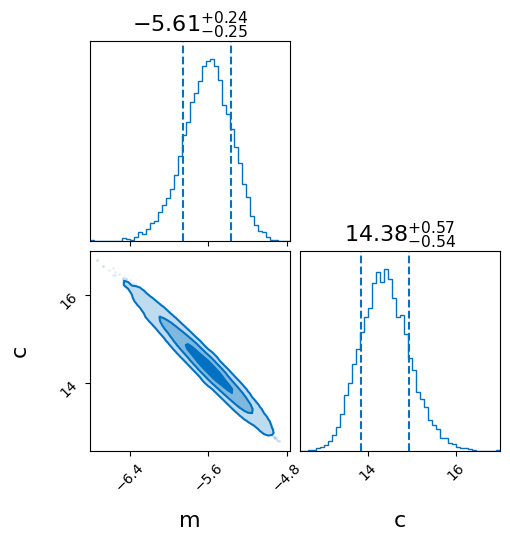

In [54]:
_ = result_unknown_x2.plot_corner(truth=dict(m=10, c=10), titles=True, save=False)

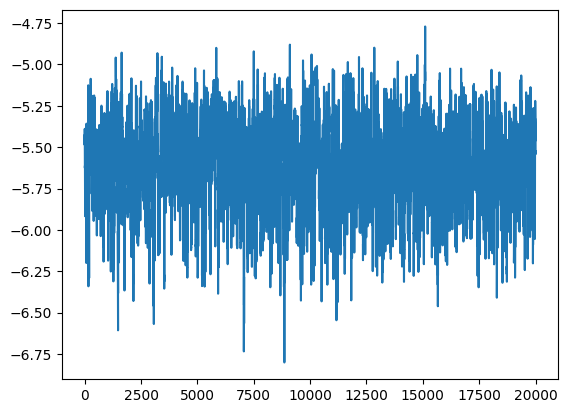

In [55]:
#samples for m
plt.plot(range(20000),result_unknown_x2.samples[:,0] )

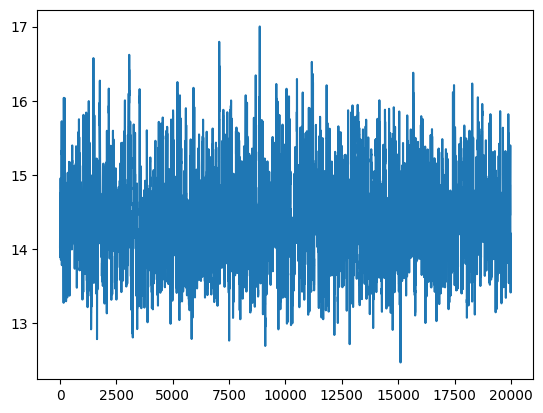

In [56]:
#samples for c
plt.plot(range(20000),result_unknown_x2.samples[:,1] )

In [57]:
#function to run inference using the mcmc fits above - outputs mean and std

def mcmc_inference(x, post_m, post_c, return_full = False):
    x = np.asarray(x)
    y = x*post_m.reshape(-1,1) + post_c.reshape(-1,1)
    if return_full is True:
        return y
    else:
        return np.mean(y, axis = 0), np.std(y, axis = 0)

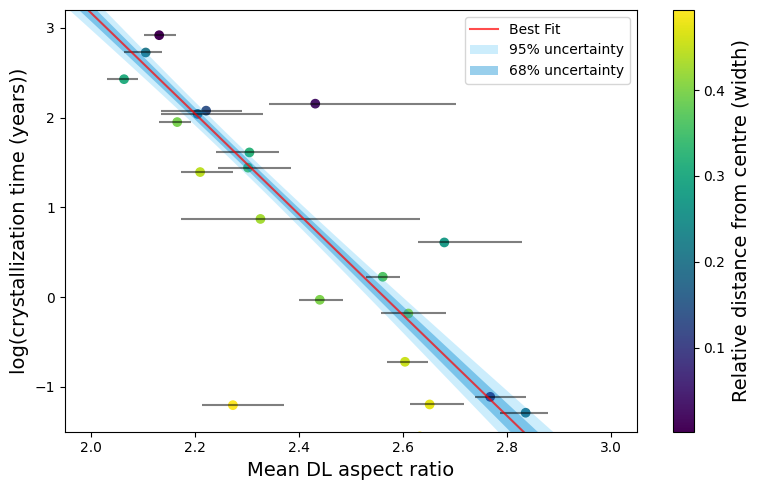

In [58]:
x_vals = np.linspace(1.9,3,100)
y, y_std = mcmc_inference(x_vals, result_unknown_x2.samples[:,0], result_unknown_x2.samples[:,1])

# Plot everything
fig, ax = plt.subplots(1,1,figsize = (8,5))

ax.errorbar(m, np.log10(tc),
 xerr=[m-np.asarray(conf_int)[:,0],np.asarray(conf_int)[:,1]-m],
 fmt = '', linestyle = '', color = 'k', alpha = 0.5)
mappable = plt.scatter(m, np.log10(tc),c=pos, cmap = "viridis")
cbar = plt.colorbar(mappable)

ax.plot(x_vals,y, label="Best Fit", c="r", alpha =0.7)
plt.fill_between(x_vals, y-2*y_std, y+2*y_std, 
                 label=r"95% uncertainty", fc="#03A9F4", alpha=0.2)
plt.fill_between(x_vals, y-y_std, y+y_std, 
                 label=r"68% uncertainty", fc="#0288D1", alpha=0.4)
ax.legend(loc = "upper right")
cbar.set_label("Relative distance from centre (width)", size = 14)
ax.set_ylabel("log(crystallization time (years))", size = 14)
ax.set_xlabel("Mean DL aspect ratio", size = 14)
ax.set_ylim([-1.5,3.2])
ax.set_xlim(1.95,3.05)
fig.tight_layout()